# General processing of flight data

In [128]:
from aux.gpx_read import *
from aux.imu_read import *
from aux.lidar_read import *
from aux.navsat_read import *
from aux.px4_read import *
from aux.rosbag_aux import *
from aux.srr308_read import *

import datetime

folder_path = 'data/50m_1'
db3_reader = get_db3_reader(folder_path, 'ROSBAG*')
db3_px4_reader = get_db3_reader(folder_path, 'sensor_bag*')

# create all data frames to find the first timestamp to reference every other DF to
radar_df = get_srr308_pointcloud_df_from_db3_reader(db3_reader)
lidar_df = get_lidar_df_from_db3_reader(db3_reader)
vel_df = get_velocity_df_from_db3_reader(db3_reader)
baro_df = get_baro_df_from_db3_reader(db3_px4_reader)

df_list = [radar_df, lidar_df, vel_df, baro_df]
first_timestamp = radar_df['timestamp_sample'][0]
for df in df_list:
    first_timestamp = min(first_timestamp, df['timestamp_sample'][0])

print("First time stamp:", datetime.datetime.fromtimestamp(first_timestamp).isoformat())

Found ROS 2 bag: data/50m_1/ROSBAG_2025-04-28_12-21-24.378/ROSBAG_2025-04-28_12-21-24.378_0.db3
Found ROS 2 bag: data/50m_1/sensor_bag_20250428_122123/sensor_bag_20250428_122123_0.db3


[INFO] [1746191754.851360827] [rosbag2_storage]: Opened database 'data/50m_1/ROSBAG_2025-04-28_12-21-24.378/ROSBAG_2025-04-28_12-21-24.378_0.db3' for READ_ONLY.
[INFO] [1746191755.131141877] [rosbag2_storage]: Opened database 'data/50m_1/sensor_bag_20250428_122123/sensor_bag_20250428_122123_0.db3' for READ_ONLY.


First time stamp: 2025-04-28T12:21:17.389383


In [129]:
## Read lidar and radar, generate altitude measurement
lidar_altitude = get_altitude_from_lidar_pc(lidar_df['np_points'], (0,0), 5)
radar_altitude = get_altitude_from_radar_pc(radar_df['points'], 0, 5)

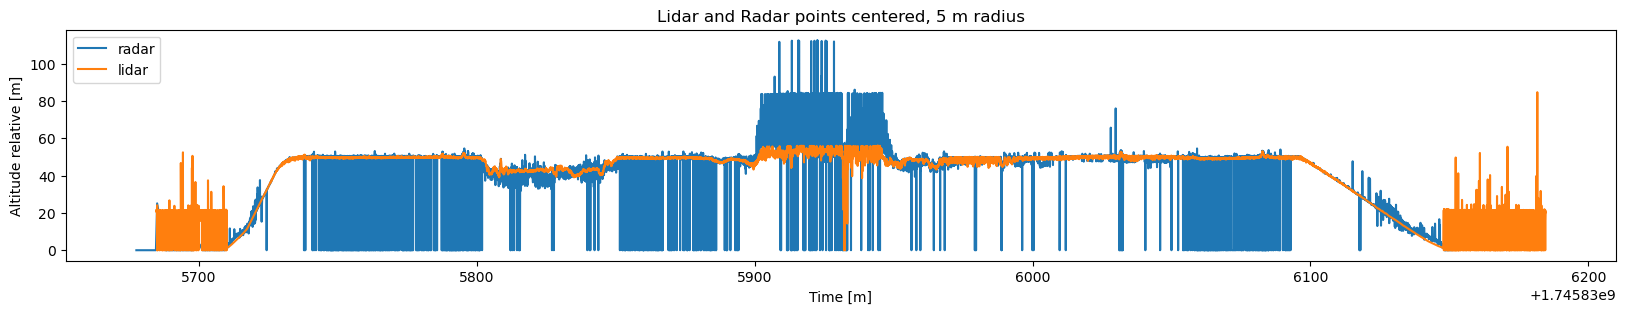

In [130]:
plt.figure(figsize=(20, 3))
plt.plot(radar_df['timestamp_sample'], radar_altitude, label='radar')
plt.plot(lidar_df['timestamp_sample'], lidar_altitude, label='lidar')
plt.title("Lidar and Radar points centered, 5 m radius")
plt.xlabel("Time [m]")
plt.ylabel("Altitude relative [m]")
plt.legend(loc="upper left") 
plt.show()

### Where and when do the static parts of the experiment take place?

In [131]:
def get_segment_index_from_ts_segments(sensor_df, reference_ts_segments):
    sensor_segments = []
    m = 0   # to comare to
    _s = -1
    _e = -1
    for i in range(sensor_df.shape[0]):
        if (m < len(reference_ts_segments)):
            ts_seg = reference_ts_segments[m]
            ts = sensor_df['timestamp_sample'][i]
            if (ts >= ts_seg[0] and _s == -1):  # first time current ts is above the lower limit
                _s = i
            if (ts <= ts_seg[1]):
                _e = i
            if (ts > ts_seg[1]):
                if (_e > _s):
                    sensor_segments.append([_s, _e])
                _s, _e = -1, -1
                m += 1
    if (_s != -1): # segment initialized but not finalized
        sensor_segments.append([_s, sensor_df.shape[0]-1])
    return sensor_segments

def get_sensor_flight_seconds(sensor_df, first_ts):
    return [sensor_df['timestamp_sample'][i]-first_ts for i in range(sensor_df.shape[0])]

In [132]:
low_limit = 0.3     # m/s
min_duration = 8    # in seconds
max_duration = 20   # in seconds
# low_limit, min_duration, max_duration = 0.2, 7, 20  #  6m1
# low_limit, min_duration, max_duration = 0.3, 8, 20  #  6m2
# low_limit, min_duration, max_duration = 0.2, 7, 15  # 50m2
# low_limit, min_duration, max_duration = 0.3, 5, 20  # 50m2
# low_limit, min_duration, max_duration = 0.3, 5, 20  # 80m1
# low_limit, min_duration, max_duration = 0.3, 7, 20  # 80m2

speed = get_speed_from_navsat_velocity_df(vel_df)

_ts_s, _ts_e = 0, 0
_s = 0

reference_timestamp_segments = []

speed_segments = []
for i in range(speed.shape[0]):
    if (speed[i] < low_limit and _ts_s == 0):  # first ts with low speed
        _ts_s = vel_df['timestamp_sample'][i]
        _s = i
    if (speed[i] > low_limit and _ts_s != 0):  # over speed threshold, already have a starting point
        _ts_e = vel_df['timestamp_sample'][i-1]
        duration = _ts_e - _ts_s
        if (duration >= min_duration and duration < max_duration):
            reference_timestamp_segments.append([_ts_s, _ts_e])
            speed_segments.append([_s, i])
        _ts_s, _ts_e = 0, 0


## show where we are in these segments | second try
navsat_df = get_navsat_df_from_db3_reader(db3_reader)
navsat_segments = get_segment_index_from_ts_segments(navsat_df, reference_timestamp_segments)

print("Segments found:", len(navsat_segments))
for i in range(len(navsat_segments)): #segment in navsat_segments:
    print("Length segment", i, "in seconds:", navsat_df['timestamp_sample'][navsat_segments[i][1]]-navsat_df['timestamp_sample'][navsat_segments[i][0]])

Segments found: 8
Length segment 0 in seconds: 12.59721040725708
Length segment 1 in seconds: 13.79000210762024
Length segment 2 in seconds: 12.994802474975586
Length segment 3 in seconds: 14.59298849105835
Length segment 4 in seconds: 14.996827602386475
Length segment 5 in seconds: 15.195786952972412
Length segment 6 in seconds: 10.026135683059692
Length segment 7 in seconds: 9.806840896606445


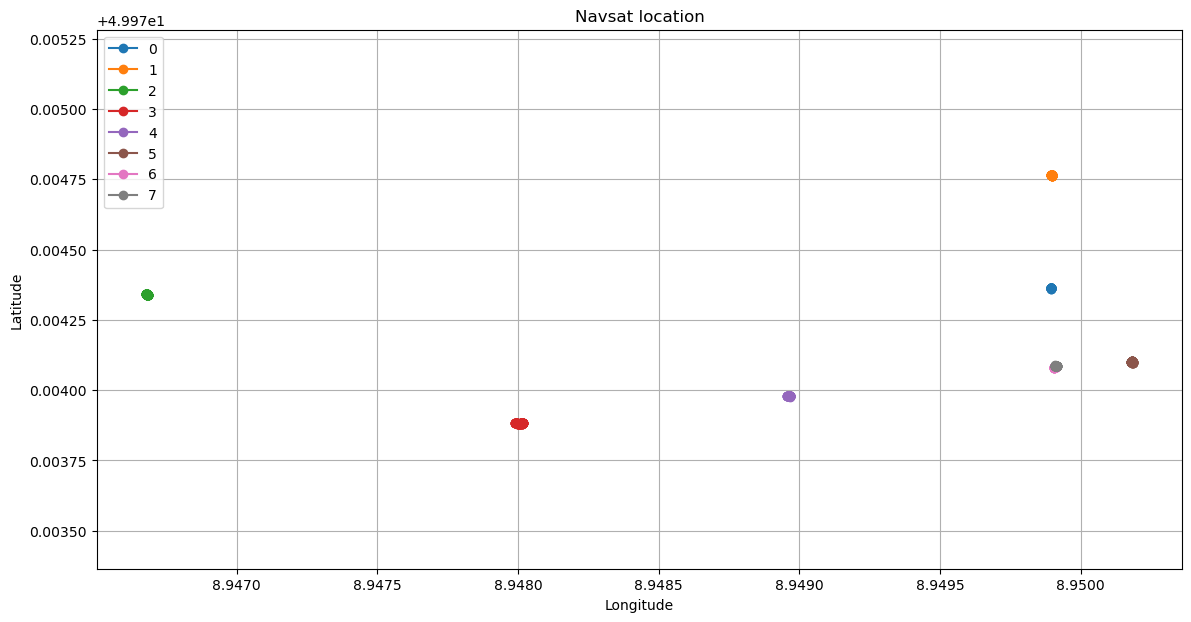

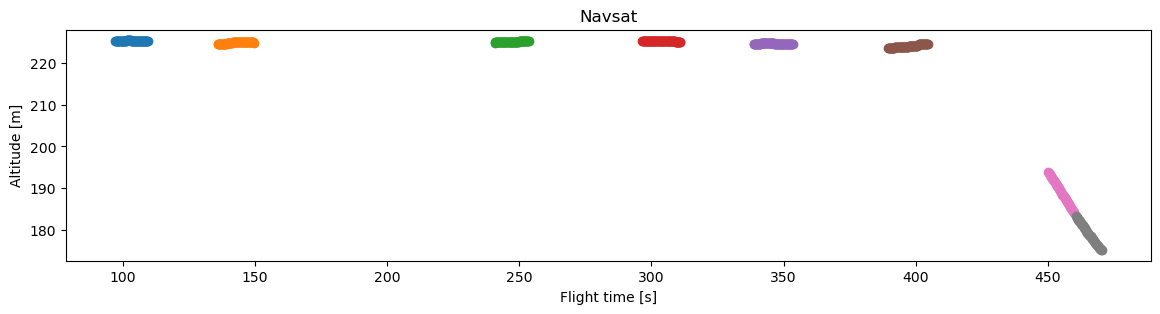

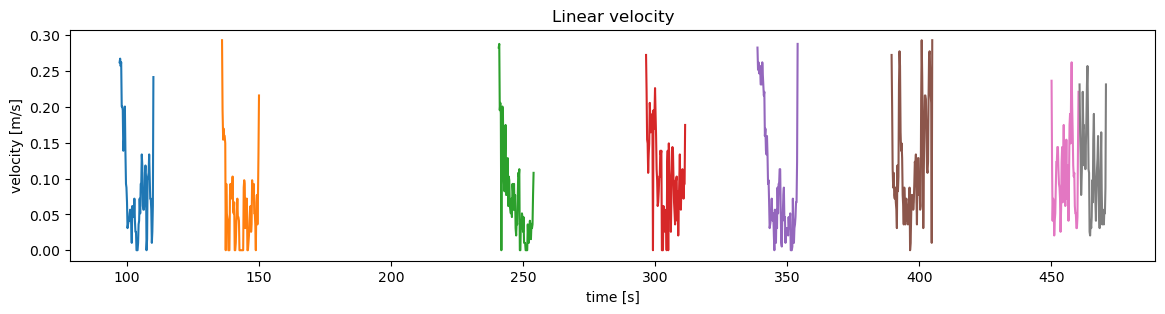

In [133]:
def plot_navsat_segments(navsat_df, segments_list, show=True):    
    plt.figure(figsize=(14, 7))
    for i in range(len(segments_list)):
        plt.plot(navsat_df['longitude'][segments_list[i][0]:segments_list[i][1]],
                 navsat_df['latitude'][segments_list[i][0]:segments_list[i][1]],
                 marker='o', linestyle='-', label=str(i))
    plt.title("Navsat location")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(loc="upper left") 
    plt.grid(True)
    plt.axis('equal')

    flight_seconds = [navsat_df['timestamp_sample'][i]-first_timestamp for i in range(navsat_df.shape[0])]

    plt.figure(figsize=(14, 3))
    for segment in segments_list:
        # plt.plot(navsat_df['timestamp_sample'][segment[0]:segment[1]], navsat_df['altitude'][segment[0]:segment[1]], marker='o', linestyle='-')
        plt.plot(flight_seconds[segment[0]:segment[1]], navsat_df['altitude'][segment[0]:segment[1]], marker='o', linestyle='-')
    plt.title("Navsat")
    plt.xlabel("Flight time [s]")
    plt.ylabel("Altitude [m]")

    if show:
        plt.show()

def plot_speed_segments(speed_list, vel_df, segments_list, show=True):
    flight_seconds = [vel_df['timestamp_sample'][i]-first_timestamp for i in range(vel_df.shape[0])]
    plt.figure(figsize=(14, 3))
    for segment in segments_list:
        plt.plot(flight_seconds[segment[0]:segment[1]], speed_list[segment[0]:segment[1]], linestyle='-')
    plt.title("Linear velocity")
    plt.xlabel("time [s]")
    plt.ylabel("velocity [m/s]")
    if show:
        plt.show()

navsat_short = navsat_df[navsat_segments[0][0]:navsat_segments[0][1]]
plot_navsat_segments(navsat_df, navsat_segments)
plot_speed_segments(speed_list=speed, vel_df=vel_df, segments_list=speed_segments)

Well keep the first 6 segments

Now, what are the altitudes from radar and lidar?

In [134]:
## same as with position, based on speed timestamps, but with radar
radar_segments = get_segment_index_from_ts_segments(radar_df, reference_timestamp_segments)
lidar_segments = get_segment_index_from_ts_segments(lidar_df, reference_timestamp_segments)

print("Number of radar segments found:", len(radar_segments))
for i in range(len(radar_segments)): #segment in radar_segments:
    print("Length segment", i, "in seconds:", radar_df['timestamp_sample'][radar_segments[i][1]]-radar_df['timestamp_sample'][radar_segments[i][0]])

print("Number of lidar segments found:", len(lidar_segments))
for i in range(len(lidar_segments)): #segment in radar_segments:
    print("Length segment", i, "in seconds:", lidar_df['timestamp_sample'][lidar_segments[i][1]]-lidar_df['timestamp_sample'][lidar_segments[i][0]])

Number of radar segments found: 8
Length segment 0 in seconds: 12.765028476715088
Length segment 1 in seconds: 13.962050676345825
Length segment 2 in seconds: 13.160198450088501
Length segment 3 in seconds: 14.72392725944519
Length segment 4 in seconds: 15.20417594909668
Length segment 5 in seconds: 15.365223407745361
Length segment 6 in seconds: 10.16408896446228
Length segment 7 in seconds: 9.963504791259766
Number of lidar segments found: 8
Length segment 0 in seconds: 12.784588813781738
Length segment 1 in seconds: 13.965114831924438
Length segment 2 in seconds: 13.165596008300781
Length segment 3 in seconds: 14.764126300811768
Length segment 4 in seconds: 15.183364152908325
Length segment 5 in seconds: 15.373406887054443
Length segment 6 in seconds: 10.159333944320679
Length segment 7 in seconds: 9.966612339019775


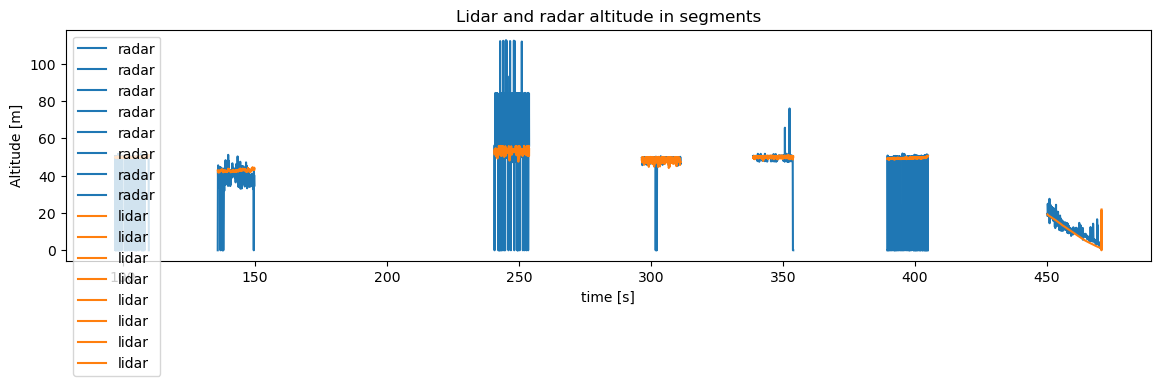

In [135]:
plt.figure(figsize=(14, 3))

radar_flight_seconds = [radar_df['timestamp_sample'][i]-first_timestamp for i in range(radar_df.shape[0])]
lidar_flight_seconds = [lidar_df['timestamp_sample'][i]-first_timestamp for i in range(lidar_df.shape[0])]

for segment in radar_segments:
    plt.plot(radar_flight_seconds[segment[0]:segment[1]], radar_altitude[segment[0]:segment[1]], linestyle='-', color="tab:blue", label="radar")

for segment in lidar_segments:
    plt.plot(lidar_flight_seconds[segment[0]:segment[1]], lidar_altitude[segment[0]:segment[1]], linestyle='-', color="tab:orange", label="lidar")

plt.title("Lidar and radar altitude in segments")
plt.xlabel("time [s]")
plt.ylabel("Altitude [m]")
plt.legend(loc="upper left") 
plt.show()

Text(0, 0.5, 'Altitude [m]')

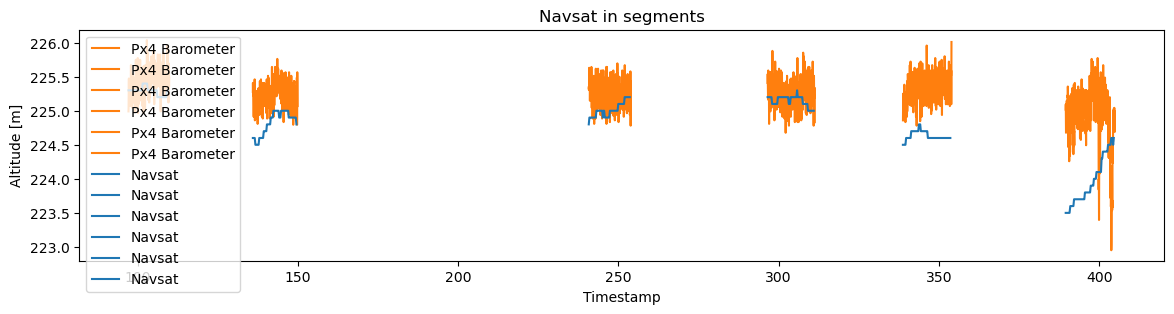

In [136]:
navsat_flight_seconds = get_sensor_flight_seconds(navsat_df, first_timestamp)

baro_segments = get_segment_index_from_ts_segments(baro_df, reference_timestamp_segments)
baro_flight_seconds = get_sensor_flight_seconds(baro_df, first_timestamp)

g = 9.80665     # [m/s^2] acceleration of gravity
rho0 = 1.2250   # [kg/m^3] mass density of air at sea level
rho0 = 1.19743  # [kg/m^3] mass density at take-off | https://www.omnicalculator.com/physics/air-density 20°C 34% 101063 Pa before take off
# p0 = 101325     # [Pa = kg/ms^2] air pressure at sea level in Pa
p0 = 101063     # [Pa = kg/ms^2] air pressure at starting point
H = p0/(rho0*g)
baro_altitude = np.log(p0/baro_df['pressure'])*H + 174

plt.figure(figsize=(14, 3))

_x = []
_y = []
for segment in baro_segments[:-2]:
    plt.plot(baro_flight_seconds[segment[0]:segment[1]], baro_altitude[segment[0]:segment[1]], linestyle='-', color="tab:orange", label="Px4 Barometer")

for segment in navsat_segments[:-2]:
    plt.plot(navsat_flight_seconds[segment[0]:segment[1]], navsat_df['altitude'][segment[0]:segment[1]], linestyle='-', color="tab:blue", label="Navsat")

plt.legend(loc="upper left") 

plt.title("Navsat in segments")
plt.xlabel("Timestamp")
plt.ylabel("Altitude [m]")

101063.5390625

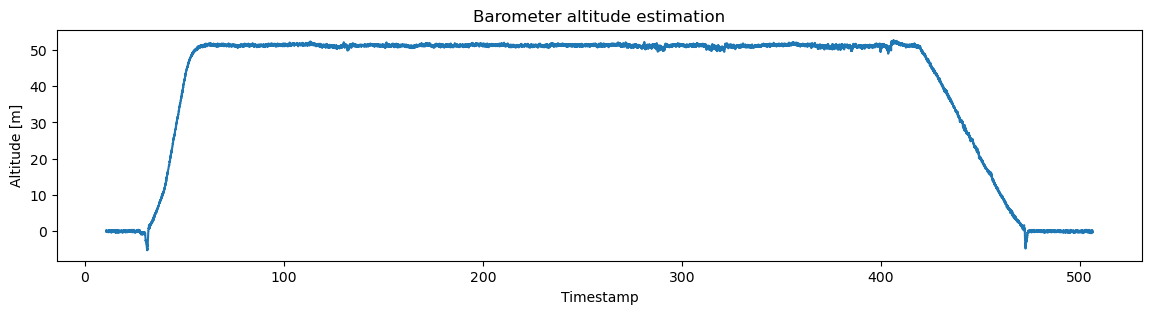

In [137]:
## get segments for barometer
baro_segments = get_segment_index_from_ts_segments(baro_df, reference_timestamp_segments)
baro_flight_seconds = get_sensor_flight_seconds(baro_df, first_timestamp)

g = 9.80665     # [m/s^2] acceleration of gravity
rho0 = 1.2250   # [kg/m^3] mass density of air at sea level
rho0 = 1.19743  # [kg/m^3] mass density at take-off | https://www.omnicalculator.com/physics/air-density 20°C 34% 101063 Pa before take off
# p0 = 101325     # [Pa = kg/ms^2] air pressure at sea level in Pa
p0 = 101063     # [Pa = kg/ms^2] air pressure at starting point

H = p0/(rho0*g)
baro_altitude = np.log(p0/baro_df['pressure'])*H

plt.figure(figsize=(14, 3))
plt.plot(baro_flight_seconds, baro_altitude, linestyle='-', color="tab:blue", label="Px4 Barometer")
plt.title("Barometer altitude estimation")
plt.xlabel("Timestamp")
plt.ylabel("Altitude [m]")
baro_df['pressure'][0]

1745835690.5227163 0.20565176010131836


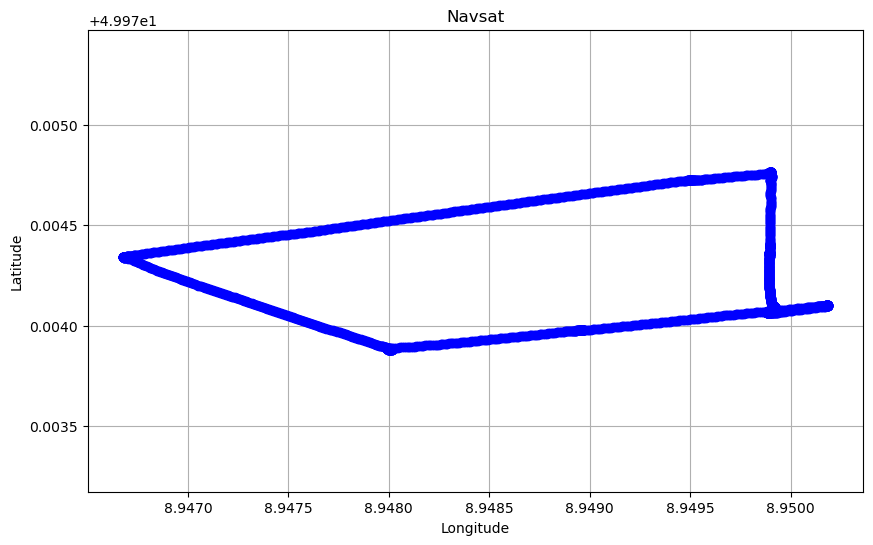

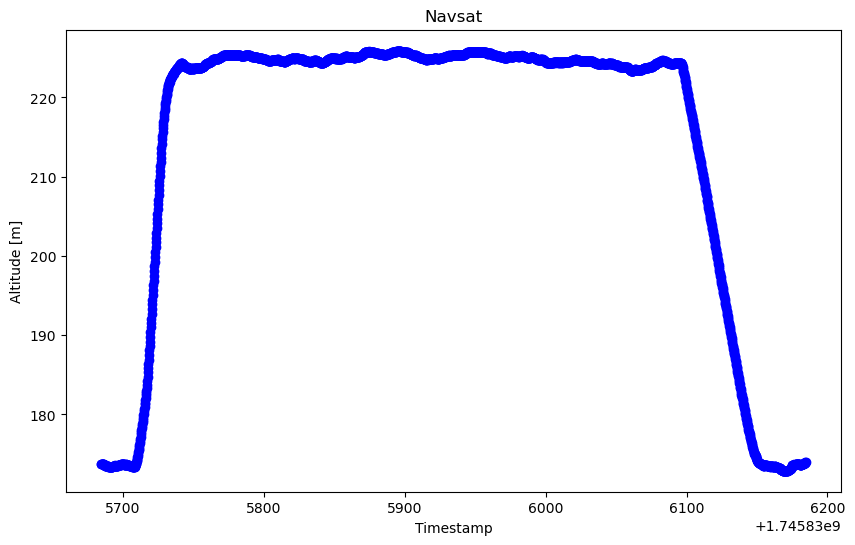

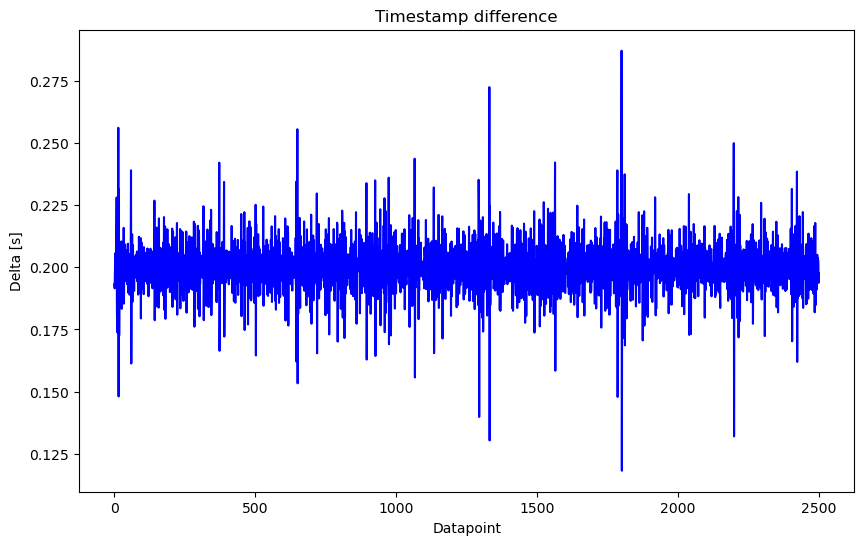

In [138]:
navsat_df = get_navsat_df_from_db3_reader(db3_reader)
plot_navsat_data_from_df(navsat_df)

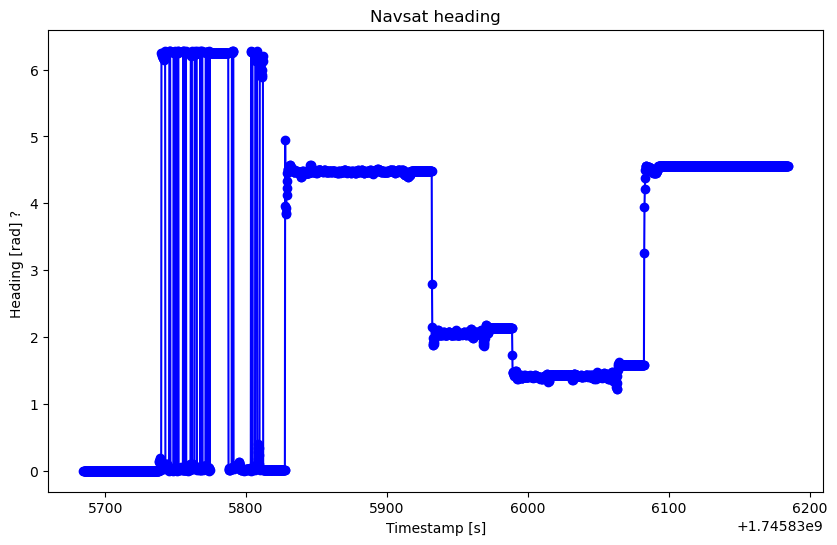

In [139]:
plot_navsat_heading_data_from_df(get_navsat_heading_df_from_db3_reader(db3_reader))

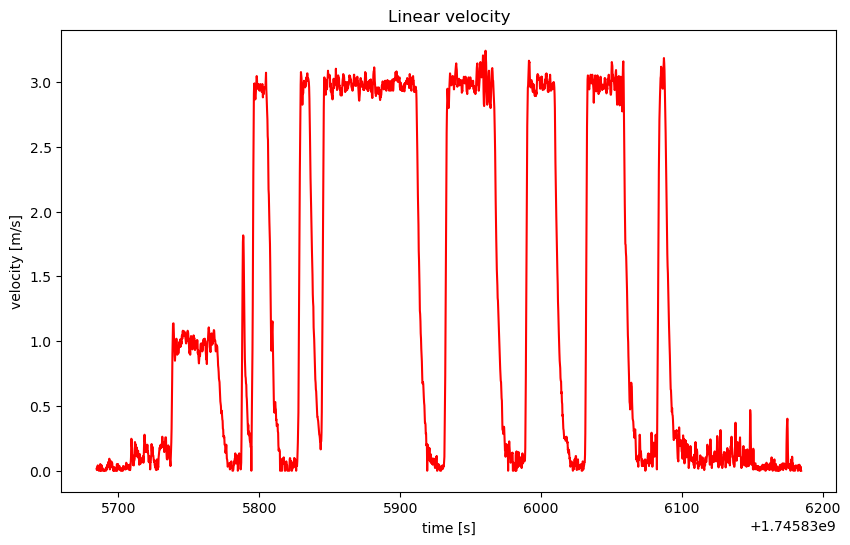

In [140]:
vel_df = get_velocity_df_from_db3_reader(db3_reader)
# plot_velocity_from_df(vel_df)

plot_speed_from_np(vel_df['timestamp_sample'], get_speed_from_navsat_velocity_df(vel_df))
plt.show()

In [141]:
speed_array = get_speed_from_navsat_velocity_df(vel_df)